In [30]:
import gymnasium as gym
import sys
from pathlib import Path
from tqdm import tqdm
import numpy as np



root = Path.cwd()
if (root / "environments").exists():
    project_root = root
elif (root.parent / "environments").exists():
    project_root = root.parent
else:
    raise RuntimeError("Cannot locate project root containing 'environments' package'")

sys.path.insert(0, str(project_root))

from environments.war_card_game_env import WarCardGameEnv
from agents.card_game_war_agent import CardGameWarAgent, card_value_difference_win_loss

from utils.visualization import plot_training_stats
from utils.helpers import test_agent


In [35]:
gym.register(
    id="WarCardGame-v1",
    entry_point=WarCardGameEnv(reward_at_end=True),
    max_episode_steps=13,
)

c:\Users\mikko\projects\openaigym\reinforcement_learning_sandbox\env\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment WarCardGame-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [36]:
env = gym.make("WarCardGame-v1")

AttributeError: 'WarCardGameEnv' object has no attribute 'split'

In [20]:
observation, info = env.reset()

In [21]:
print("Initial observation:", observation)
print("Info:", info)

Initial observation: {'player1_cards': [], 'player2_cards': [], 'round_number': 0}
Info: {'player1_played_cards': [], 'player2_played_cards': [], 'round_number': 0}


In [22]:
action = env.action_space.sample()
print("Sampled action:", env.action_space.sample())

Sampled action: 0


In [23]:
observation, reward, terminated, truncated, info = env.step(action)

c:\Users\mikko\projects\openaigym\reinforcement_learning_sandbox\env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(
c:\Users\mikko\projects\openaigym\reinforcement_learning_sandbox\env\Lib\site-packages\gymnasium\spaces\box.py:424: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\mikko\projects\openaigym\reinforcement_learning_sandbox\env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [24]:
print("Initial observation:", observation)
print("Reward", reward)
print("Terminated:", terminated)
print("Truncated:", truncated)
print("Info:", info)

Initial observation: {'player1_cards': [7], 'player2_cards': [7], 'round_number': 1}
Reward 0.0
Terminated: False
Truncated: False
Info: {'player1_played_cards': [7], 'player2_played_cards': [7], 'round_number': 1}


In [25]:

observation, info = env.reset()
episode_over = False
total_reward = 0
print("\nStarting new episode...\n")
print("Initial observation:", observation)
while not episode_over:

    action =  np.random.choice([card for card in range(13) if card not in observation["player1_cards"]])

    observation, reward, terminated, truncated, info = env.step(action)
    print("Observation:", observation)
    print("Reward:", reward)
    print("Terminated:", terminated)
    print("Truncated:", truncated)
    print("Info:", info)

    total_reward += reward
    episode_over = terminated or truncated

print(f"Episode finished! Total reward: {total_reward}")

env.close()



Starting new episode...

Initial observation: {'player1_cards': [], 'player2_cards': [], 'round_number': 0}
Observation: {'player1_cards': [11], 'player2_cards': [12], 'round_number': 1}
Reward: -1.0
Terminated: False
Truncated: False
Info: {'player1_played_cards': [11], 'player2_played_cards': [12], 'round_number': 1}
Observation: {'player1_cards': [3, 11], 'player2_cards': [6, 12], 'round_number': 2}
Reward: -1.0
Terminated: False
Truncated: False
Info: {'player1_played_cards': [3, 11], 'player2_played_cards': [6, 12], 'round_number': 2}
Observation: {'player1_cards': [3, 10, 11], 'player2_cards': [3, 6, 12], 'round_number': 3}
Reward: 1.0
Terminated: False
Truncated: False
Info: {'player1_played_cards': [3, 10, 11], 'player2_played_cards': [3, 6, 12], 'round_number': 3}
Observation: {'player1_cards': [0, 3, 10, 11], 'player2_cards': [3, 5, 6, 12], 'round_number': 4}
Reward: -1.0
Terminated: False
Truncated: False
Info: {'player1_played_cards': [0, 3, 10, 11], 'player2_played_cards'

In [26]:
learning_rate = 0.05
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1
env = gym.make("WarCardGame-v0")
env.reset()



agent = CardGameWarAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    reward_function=card_value_difference_win_loss,
)
agent.change_reward_function(card_value_difference_win_loss)

c:\Users\mikko\projects\openaigym\reinforcement_learning_sandbox\env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(
c:\Users\mikko\projects\openaigym\reinforcement_learning_sandbox\env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [28]:
env.reward_function(12,8)

0.2222222222222222

In [29]:
env.reward_at_the_end

AttributeError: 'TimeLimit' object has no attribute 'reward_at_the_end'

In [6]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 0/100000 [00:00<?, ?it/s]c:\Users\mikko\projects\openaigym\reinforcement_learning_sandbox\env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(
c:\Users\mikko\projects\openaigym\reinforcement_learning_sandbox\env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
100%|██████████| 100000/100000 [05:08<00:00, 323.68it/s]


In [12]:
test_agent(agent, env)

Test Results over 1000 episodes:
Win Rate: 42.9%
Average Reward: 0.085
Standard Deviation: 1.868


In [13]:
agent.training_error

[np.float64(1.0),
 np.float64(1.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(0.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(0.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(0.95),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(-1.05),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(-1.0),
 np.float64(1.0),
 np.float64(1.0),
 n

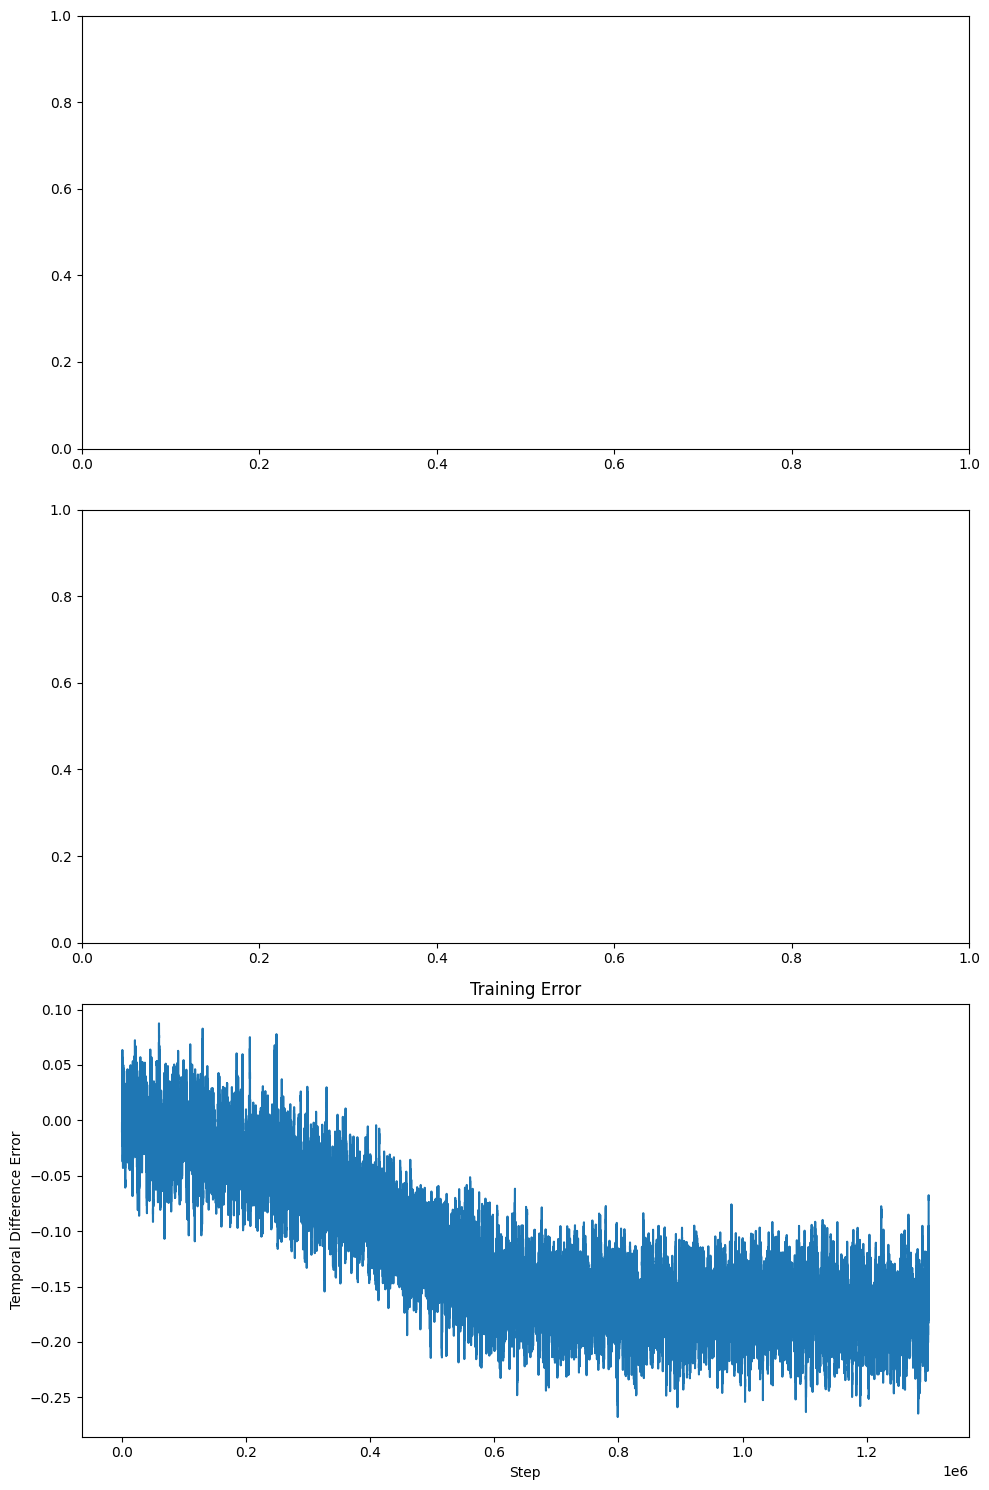

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return (
        np.convolve(np.array(arr).flatten(), np.ones(window), mode=convolution_mode)
        / window
    )



fig, axs = plt.subplots(3, 1, figsize=(10, 15))
# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error, 500, "same"
)
axs[2].plot(
    range(len(training_error_moving_average)), training_error_moving_average
)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 5))


In [20]:
agent.reward_function(1,9)

TypeError: 'float' object is not callable

In [21]:
env.self_reward_function

AttributeError: 'TimeLimit' object has no attribute 'self_reward_function'